__This notebook generates data for the following notebooks such as bee view images as well as coordinates of the bee's viewing area and the copter's gps position during flights.__

In [ ]:
%matplotlib inline
import generate_bee_views.beeview as beeview
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import sys
import csv
import geopy.distance

import bee_view_analyzer.Utils as Utils

In [ ]:
# Ignore roll and pitch movements of copter (to create bee views which do not change their shapes in turns)
YAW_ONLY = False

In [ ]:
# files with recorded data of different flights with following array indices:
# 0: subfolder of file
# 1: file name
# 2: index of voltage column in csv file (number of of columns varies between different files up to this column but
#     is equally afterwards such that specific columns such as GPS values can be calculated from this voltage
#      column later)
csv_files = [
    ['flight_2018_09_03#1', '030918_01_out_adc_synced.csv_spike_rates_0.1s_intervalls.csv', 9],
    ['flight_2018_09_03#1', '030918_01_out_adc_synced.csv_spike_rates_0.01s_intervalls.csv', 9],
    ['flight_2018_09_03#1', '030918_01_out_adc_synced.csv_spike_rates_1.0s_intervalls.csv', 9],
    ['flight_2018_09_03#2', '030918_2_out_adc_synced.csv_spike_rates_0.1s_intervalls.csv', 3],
    ['flight_2018_09_03#3', '030918_3_out_adc_synced.csv_spike_rates_0.1s_intervalls.csv', 3],
    ['flight_2018_09_03#4', '030918_4_out_adc_synced.csv_spike_rates_0.1s_intervalls.csv', 3],
    ['flight_2018_08_02#1', '020818_out_adc_synced.csv.txt_spike_rates_0.1s_intervalls.csv', 12],
    ['flight_2018_08_02#2', '020818_out_adc_synced.csv_spike_rates_0.1s_intervalls.csv', 3],
]

In [ ]:
# index of csv_file_names from which GPS positions etc of copter will be used
FILE_NUM = 0

csv_file_path = Utils.get_path(['flights', csv_files[FILE_NUM][0]], csv_files[FILE_NUM][1])
voltage_column = csv_files[FILE_NUM][2]

In [ ]:
# Each frame holds the copter`s data in a specific moment (dependent on the chosen intervall, see csv_files)
class Frame:    
    def __init__(self, csv_row = None, ground_level = 0, prev_frame = None, coord = None, height = 0):
        self.radar_coords = (52.459798, 13.298177) # from google maps (lat, long)
        
        if (csv_row is not None):
            # load data from csv file
            
            self.timestamp = float(row[0])
            self.relative_height = float(row[voltage_column + 54]) if row[voltage_column + 54] else 0
            
            # IMU_ATTI gps columns:
            lat = row[voltage_column + 16]
            long = row[voltage_column + 15]
            
            # first rows do not contain lat & long data, then the origin position of the 3D model is set
            if lat != "" and long != "":
                coords = [float(lat), float(long)]       # lat, long
            else:
                coords = self.radar_coords
            
            self.x, self.y = self.__convert_coords(coords)
            self.position = [self.x, self.__get_height(ground_level, self.relative_height), self.y]
        
            if YAW_ONLY:
                self.roll = 0
                self.pitch = 0.3
            else:            
                self.roll = float(row[voltage_column + 38])
                self.pitch = float(row[voltage_column + 39])
            
            self.yaw = float(row[voltage_column + 40])
            
        elif (coord is not None):
            # set agent at a chosen GPS position (= coord)
            
            self.x, self.y = self.__convert_coords(coord)
            self.relative_height = height
            self.position = [self.x, self.__get_height(ground_level, self.relative_height), self.y]
        
        # calulcate flight direction with the coper´s position of the previous frame
        if (prev_frame is not None):
            self.direction = np.array(self.position) - np.array(prev_frame.get_position())
            
            if (self.direction[0] == 0 and self.direction[2] == 0):
                self.direction = np.array(prev_frame.get_direction())
        
    def get_timestamp(self):
        return self.timestamp
    
    def get_x(self):
        return self.x
    
    def get_y(self):
        return self.y
    
    def get_position(self):
        return self.position
    
    def get_direction(self):
        #return self.direction
        return [0, 0, 1]
    
    def get_roll_left(self):
        return self.roll
    
    def get_rotation_down(self):
        return self.pitch
    
    def get_rotation_right(self):
        return self.yaw
    
    def __get_height(self, ground_level, relative_height):
        #return ground_level + 20
        return ground_level + relative_height
    
    def __convert_coords(self, coords):
        """ convert the gps coordinates to the coordinates used by beeview """
        
        dist_y = geopy.distance.geodesic(self.radar_coords,(coords[0], self.radar_coords[1])).m
        dist_x = geopy.distance.geodesic(self.radar_coords,(self.radar_coords[0], coords[1])).m
    
        if self.radar_coords[1] > coords[1]:
            dist_x *= (-1)
        
        if self.radar_coords[0] > coords[0]:
            dist_y *= (-1)
    
        return (dist_x, dist_y)

# Read input and initialize

In [ ]:
# use berlin_august.obj model if a csv file of a flight from august was chosen

model_path = Utils.get_path(['01_generate_bee_views', '3D_models', 'Berlin'], 'berlin_september.obj')
#model_path = Utils.get_path(['01_generate_bee_views', '3D_models', 'Berlin'], 'berlin_august.obj')

renderer = beeview.Renderer(model_path,  Utils.get_path(['generate_bee_views'], 'ommatidia.csv'),
                            left_handed = True)

renderer.set_num_samples(30)
renderer.set_acceptance_angle(2.6)
renderer.set_ommatidium_size(1)

In [ ]:
frames = []

with open(csv_file_path) as csvfile:
    neuroReader = csv.reader(csvfile)
    
    ground_level = 0
    prev_frame = None
    first_frame = True
    
    for row in neuroReader:
        if (first_frame):
            first_frame = False
            
            prev_frame = Frame(csv_row = row)
            
            # if 3D is loaded, use it to calculate the actual distance to ground
            if 'renderer' in globals():
                distance_ground = renderer.measure_distance([prev_frame.get_x(), 500, prev_frame.get_y()],
                                                            [0, -1, 0])
                ground_level = 500 - distance_ground if distance_ground > 0 else distance_ground
            else:
                ground_level = 0
        else:
            frame = Frame(csv_row = row, ground_level = ground_level, prev_frame = prev_frame)
            frames.append(frame)
            
            prev_frame = frame

# Render helper

In [ ]:
def render(position, direction, roll_left_degree = 0, rotate_down_degree = 0, rotate_right_degree = 0, mode = 0):
    renderer.position = position
    renderer.direction = direction
    renderer.mode = mode  
    
    renderer.roll_left(roll_left_degree)
    renderer.rotate_down(rotate_down_degree)
    renderer.rotate_right(rotate_right_degree)
    
    img = renderer.render()
    
    renderer.roll_right(roll_left_degree)
    
    return img

def save_img(img, name, directory):
    img = Image.fromarray(img)
    img.save(directory + "{}.png".format(name))

def render_frame(frame_number, show_img = False, save_image = True, save_dir = "", mode = 0):
    frame = frames[frame_number]
    
    position = frame.get_position()
    direction = frame.get_direction()
    img = render(position, direction, frame.get_roll_left(), frame.get_rotation_down(), frame.get_rotation_right(),
                 mode)
    
    if show_img:
        plt.imshow(img)
        
    if save_image:
        name = str(frame_number)
        
        if frame_number < 10:
            name = "000" + name
        elif frame_number < 100:
            name = "00" + name
        elif frame_number < 1000:
            name = "0" + name
        
        save_img(img, name, save_dir)

# Test with example coordinates

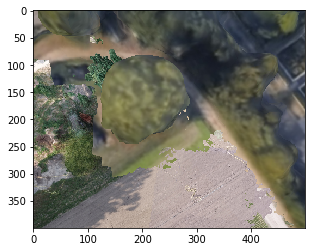

In [ ]:
right_bottom = [52.460355, 13.299145]
right_top = [52.462292, 13.296833]
left_bottom = [52.459120, 13.296086]

testFrame = Frame(coord = right_top, height = 50)

position = testFrame.get_position()
direction = [0, -1, 0.1]

img = render(position, direction, mode = 2)
plt.imshow(img)

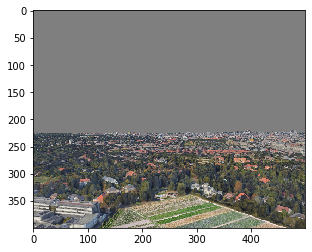

In [ ]:
from math import cos, sin

coord = [52.4589534, 13.2964825]
testFrame = Frame(coord = coord, height = 100)

position = testFrame.get_position()

roll = -0.167152981327058
pitch = -2.9954656950717005
yaw = -37.41739979580584

renderer.position = position
renderer.direction = [0, 0, 1]
renderer.mode = 2

renderer.rotate_up(pitch)
#renderer.rotate_left(yaw)
renderer.roll_right(roll)

img = renderer.render()

plt.imshow(img)

renderer.roll_left(roll)

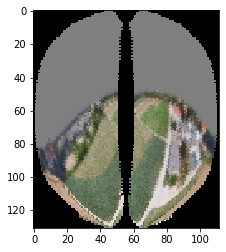

In [ ]:
render_frame(1185, show_img = True, save_image = False)

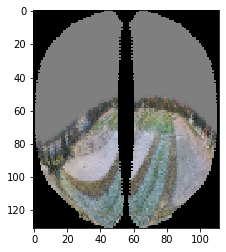

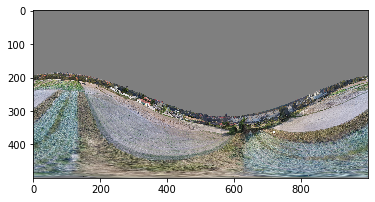

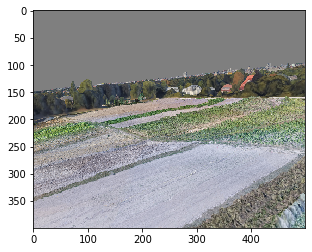

In [ ]:
frame = 1400

render_frame(frame, show_img = True, save_image = False)
plt.show()

render_frame(frame, show_img = True, save_image = False, mode=1)
plt.show()

render_frame(frame, show_img = True, save_image = True, mode=2)
plt.show()

# Generate bee views

In [ ]:
bee_img_path = Utils.get_path(['flights', 'flight_2018_09_03#1', 'bee_eye', 'img'], '')

for i in range(0, len(frames)):    
    render_frame(i, save_dir = bee_img_path, mode = 0)

# Generate Map coordinates

Calculate intersection points of ray casts and 3D model during generating a bee view. Coordinates of these intersection points are used to project the bee's brain activity onto the field in jupyter notebook '4_map_projection.ipynb'.

See https://github.com/tobiasschuelke/bee_view for the source code of the modified bee view library.

In [ ]:
def get_coordinates(frame_number):
    frame = frames[frame_number]
    
    renderer.position = frame.get_position()
    renderer.direction = frame.get_direction()  
    
    renderer.roll_left(frame.get_roll_left())
    renderer.rotate_down(frame.get_rotation_down())
    renderer.rotate_right(frame.get_rotation_right())
    
    coord = renderer.get_bee_eye_3D_coordinates()
    
    renderer.roll_right(frame.get_roll_left())
    
    return coord

## Single ray casts per ommatidium

Returns one intersection point per ommatidium although the bee view library shoots multiple ray casts per ommatidium. Takes less time for later analysis and needs less memory space.

A modified version of the bee view library is needed. Rename file '\generate_bee_views\beeview.cp37-win_amd64_single_ray_shot.pyd' to '\generate_bee_views\beeview.cp37-win_amd64.pyd' and rerun this notebook. Otherwise, renderer.get_bee_eye_3D_coordinates() is not defined.

In [ ]:
renderer.mode = 0

coords = []

for i in range(len(frames)):
    coords.append(get_coordinates(i))
    
path = Utils.get_path(['flights', 'flight_2018_09_03#1'], 'coords.dill')
Utils.save_object(path, coords)

## Multiple ray casts per ommatidium

In order to calculate intersection points off all ray casts that are shot during generation of a bee view, a modified version of the bee view must be used. The saved data is split into multiple files to avoid one huge file.

To get all ray casts per ommatidium via renderer.get_bee_eye_3D_coordinates(), rename file '\generate_bee_views\beeview.cp37-win_amd64_multiple_ray_shots' to '\generate_bee_views\beeview.cp37-win_amd64.pyd' and rerun this notebook.

In [ ]:
coords = []
camera_positions = []

renderer.mode = 0

start_frame = 600
split_frame_count = 100
splits = 0

def save_coords(splits, coords):
    path = Utils.get_path(["flights", "flight_2018_09_03#1", "coords", "coords_multiple_ray_casts"],
                          "coords_with_samples_{}.dill".format(splits))
    Utils.save_object(path, coords)

for i in range(start_frame, len(frames)):
    if i % 20 == 0:
        sys.stdout.write('\rFrame: {}'.format(i))
    
    if i > start_frame and i % split_frame_count == 0:
        save_coords(splits, coords)        
        coords = []
        splits += 1
    
    coords.append(get_coordinates(i))
    camera_positions.append(get_camera_position(i))
    
save_coords(splits, coords)

Frame: 6940

# Copter positions

Write GPS coordinates of the copter during the flight in a file.

In [ ]:
camera_positions = []

for i in range(len(frames)):
    frame = frames[i]
    camera_positions.append(frame.get_position())
    
path = Utils.get_path(["flights", "flight_2018_09_03#1"], "camera_positions.dill")
Utils.save_object(path, camera_positions)

# Map bounds

Calculate coordinates of each corner of the field given their GPS positions. These coordinates are used to determine whether an intersection point between a ray cast and the 3D model is located on the field or on the surrounding environment.

In [ ]:
left = [52.460691, 13.295426]
top = [52.462308, 13.296831]
right = [52.460354, 13.299203]
bottom = [52.459112, 13.296068]

for pos in [left, top, right, bottom]:
    testFrame = Frame(coord = pos, height = 100)
    print(testFrame.get_position())

[-186.9914125059584, 100, 99.36954010633316]
[-91.49052753356315, 100, 279.3030010782651]
[69.73943629260407, 100, 61.869499122172805]
[-143.35328570883112, 100, -76.33538114425568]


# Autoencoder training data

Generate bee view images from random positions on the field while maintaining possible orientations while flying with the copter. The field template object is loaded to determine positions which belong only to the field and not the surrounding environment which is also part of the berlin_august.obj model.

In [ ]:
template_path = Utils.get_path(['01_generate_bee_views', '3D_models', 'Berlin'], 'berlin_field_template.obj')
ommatidia_path = Utils.get_path(['01__generate_bee_views'], 'ommatidia.csv')
renderer_field_template = beeview.Renderer(template_path, ommatidia_path, left_handed = True)

bounds_template = renderer_field_template.get_scene_bounds()

bound_field_left = bounds_template[0][0]
bound_field_right = bounds_template[1][0]
bound_field_bottom = bounds_template[0][2]
bound_field_top = bounds_template[1][2]

bounds_template

In [ ]:
def save_img(img, name, directory):
    img = Image.fromarray(img)
    img.save(directory + "{}.png".format(name))

In [ ]:
height = 10
render_pinhole = False

training_path = Utils.get_path(['02_autoencoder', 'training_data_september', 'bee_eye'], '')
training_pinhole_path = Utils.get_path(['02_autoencoder', 'training_data_september', 'pinhole'], '')
#training_path = Utils.get_path(['02_autoencoder', 'training_data_august', 'bee_eye'], '')

i = 0
while True:
    x = np.random.uniform(bound_field_left, bound_field_right)
    y = np.random.uniform(bound_field_bottom, bound_field_top)
    
    is_on_field = renderer_field_template.measure_distance([x, 800, y], [0, -1, 0]) > -1
    
    if not is_on_field:
        continue
    
    distance_ground = renderer.measure_distance([x, 800, y], [0, -1, 0])
        
    i += 1
    
    ground_level = 800 - distance_ground
    z = ground_level + np.clip(np.random.normal(height, 7), 3, np.inf)
    
    position = [x, z, y]
    
    renderer.position = position
    renderer.direction = [np.random.uniform(-1, 1), np.random.normal(0, 0.05), np.random.uniform(-1, 1)]
    renderer.mode = 0
    img = renderer.render()
    save_img(img, i, training_path)
    
    if render_pinhole:
        renderer.mode = 2
        img = renderer.render()
        save_img(img, i, training_pinhole_path)    
    
    sys.stdout.write("\r {}".format(i))
    
    if i >= 100000:
        break